In [1]:
# TBD 1 : logger 추가
# TBD 2: flask github 참고, method, class, 파일의 맨 윗단 마다 pydoc 형식으로 달기
# TBD 3: 축약어를 자제할것 (특히 변수)

# -------------------------
#   done
# -------------------------

# 0. add data-setter, receiver system use python queue.Queue() class
# this will resolve i/o bottleneck
# 3. make iterable

# -------------------------
#   In Progress
# -------------------------

# 1. add logger
# 2. make image drawer overlay mask on image

# -------------------------
#   To be Done
# -------------------------

# 4. make verbose turn on and off
# 5. write pydoc

# python basic Module
import os
import sys
import types
import progressbar
from datetime import datetime
from shutil import copy
from pickle import dump, load

# math, image, plot Module
import numpy as np
import cv2
import matplotlib.pyplot as plt  # TBD

# tensorflow Module
import tensorflow as tf
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import losses

# keras segmentaion third-party Moudle
import segmentation_models as sm
import tensorflow_addons as tfa

# custom Module
from gan_module.data_loader.medical_segmentation_data_loader import DataLoader
from gan_module.data_loader.manage_batch import BatchQueueManager

from gan_module.model.build_model import build_generator as build_generator
from gan_module.model.build_model import build_discriminator as build_discriminator
from gan_module.util.custom_loss import weighted_region_loss, dice_score, combined_loss, f1_loss
# from gan_module.util.custom_gradient import SGD_AGC
from gan_module.util.manage_learning_rate import learning_rate_scheduler
from gan_module.util.draw_images import ImageDrawer
from gan_module.util.logger import TrainLogger
from gan_module.config import CONFIG

USE_GPU = True

if USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


class Pix2PixSegmentation:
    def __init__(
        self,
        generator_power=32,
        discriminator_power=32,
        generator_depth = None,
        discriminator_depth = None,
        generator_learning_rate=1e-4,
        discriminator_learning_rate=1e-4,
        temp_weights_path=".",
        on_memory=True,
        code_test=False
    ):
        # Input shape
        img_shape = CONFIG["img_shape"]
        input_channels = CONFIG["input_channels"]
        output_channels = CONFIG["output_channels"]

        self.input_img_shape = (*img_shape, input_channels)
        self.output_img_shape = (*img_shape, output_channels)
        # set parameter
        self.start_epoch = None
        self.on_memory = on_memory
        self.history = {"generator_loss": [],
                        "f1_loss_train": [], "f1_score_train": [],
                        "f1_loss_valid": [], "f1_score_valid": []}
        self.temp_weights_path = temp_weights_path

        # Configure data loader
        self.dataset_name = "glomerulus_0.65_512_remove_peel_split_man"
        self.data_loader = DataLoader(
            dataset_name=self.dataset_name,
            config_dict=CONFIG,
            on_memory=self.on_memory, 
            code_test=code_test
        )
        
        self.train_logger = TrainLogger()
        
        self.loaded_data_index = {
            "train": np.arange(self.data_loader.data_length["train"]),
            "valid": np.arange(self.data_loader.data_length["valid"])
        }
        
        # Configure Image Drawer
        self.image_drawer = ImageDrawer(
            dataset_name=self.dataset_name, data_loader=self.data_loader
        )
        self.discriminator_loss_ratio = keras_backend.variable(0.1)
        self.f1_loss_ratio = keras_backend.variable(100)
        self.discriminator_losses = np.array(
            [1 for _ in range(self.data_loader.data_length["train"])], dtype=np.float32)
        self.discriminator_acc_previous = 0.5
        self.discriminator_acces = np.array(
            [0.5 for _ in range(self.data_loader.data_length["train"])])
        self.discriminator_acces_previous = self.discriminator_acces.copy()
        self.generator_losses = np.array(
            [1 for _ in range(self.data_loader.data_length["train"])], dtype=np.float32)
        self.generator_losses_previous = self.generator_losses.copy()
        self.generator_f1_losses = np.array(
            [1 for _ in range(self.data_loader.data_length["train"])], dtype=np.float32)
        self.generator_loss_min = 10000
        self.generator_loss_previous = 10000
        self.generator_loss_max_previous = 10000
        self.generator_valid_loss_min = 10000
        self.total_f1_loss_min = 10000
        self.weight_save_stack = False
        self.training_end_stack = 0
        # Calculate output shape of D (PatchGAN)
        self.disc_patch = (img_shape[0] // (2 ** discriminator_depth), img_shape[1] // (2 ** discriminator_depth), 1)
        # Number of filters in the first layer of G and D
        self.generator_learning_rate = generator_learning_rate
        self.discriminator_learning_rate = discriminator_learning_rate
        self.patience_count = 0
        
        generator_optimizer = Nadam(self.generator_learning_rate)
        discriminator_optimizer = Nadam(self.discriminator_learning_rate)
#         generator_optimizer = SGD_AGC(lr=self.generator_learning_rate, momentum=0.9)
#         discriminator_optimizer = SGD_AGC(lr=self.discriminator_learning_rate, momentum=0.9)        
        # Build the generator
        self.generator = build_generator(
            input_img_shape=self.input_img_shape,
            output_channels=output_channels,
            generator_power=generator_power,
            depth=generator_depth,
        )
        self.generator.compile(
            loss=weighted_region_loss,
            optimizer=generator_optimizer,
            metrics=[dice_score],
        )
        # Build and compile the discriminator
        self.discriminator = build_discriminator(
            input_img_shape=self.input_img_shape,
            output_img_shape=self.output_img_shape,
            discriminator_power=discriminator_power,
            depth=discriminator_depth,
        )
        # 'mse' or tf.keras.losses.Huber() tf.keras.losses.LogCosh()
        self.discriminator.compile(
            loss=sm.losses.BinaryFocalLoss(alpha=0.25, gamma=4),
            optimizer=discriminator_optimizer,
            metrics=["accuracy"],
        )
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # -------------------------
        # Construct Computational
        #   Graph of Generator
        # -------------------------

        # Input images and their conditioning images
        original_img = Input(shape=self.input_img_shape)
        # generate image from original_img for target masked_img
        model_masked_img = self.generator(original_img)
        
    
        # Discriminators determines validity of translated images / condition pairs
        model_validity = self.discriminator([original_img, model_masked_img])
        # give score by
        # 1. how generator trick discriminator
        # 2. how generator's image same as real photo in pixel
        # 3. if you want change loss, see doc https://keras.io/api/losses/
        # 4. 'mse', 'mae', tf.keras.losses.LogCosh(),  tf.keras.losses.Huber()
        self.combined = Model(
            inputs=original_img,
            outputs=[model_validity, model_masked_img],
        )
        
        self.combined.compile(
            loss=[
#                 tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
                sm.losses.BinaryFocalLoss(alpha=0.25, gamma=4),
                weighted_region_loss
            ],
            loss_weights=[0.1, 100],
            optimizer=generator_optimizer,
        )

    def train(self, epochs, batch_size=1, epoch_shuffle_term=10):

        start_time = datetime.now()

        # Adversarial loss ground truths
        self.training_end_stack = 0
        self.batch_size = batch_size
        valid_patch = np.ones(
            (self.batch_size, *self.disc_patch), dtype=np.float32)
        fake_patch = np.zeros(
            (self.batch_size, *self.disc_patch), dtype=np.float32)
        # TBD : move batch_queue_manager to __init__
        self.batch_queue_manager = BatchQueueManager(self, batch_size, self.on_memory)
        
        if self.start_epoch is None:
            self.start_epoch = 0
        for epoch in range(self.start_epoch, epochs):
            batch_i = 0

            generator_loss_max_in_epoch = 0
            generator_loss_min_in_epoch = 1000
            generator_discriminator_losses = np.array(
            [1 for _ in range(self.data_loader.data_length["train"])], dtype=np.float32)
            # shffle data maybe
            if epoch % epoch_shuffle_term == 0:
                self.data_loader.shuffle_train_imgs()
            
            if self.discriminator_acc_previous < 0.95:
                discriminator_learning = True
            else:
                discriminator_learning = False
            generator_1_10_quantile = np.quantile(self.generator_losses, 0.1)
            
            
            generator_current_learning_rate = learning_rate_scheduler(
                self.generator_learning_rate,
                epoch+self.patience_count,
                warm_up=True
            )
            discriminator_current_learning_rate = learning_rate_scheduler(
                self.discriminator_learning_rate,
                epoch+self.patience_count,
                warm_up=True
            ) * (1 - self.discriminator_acc_previous)
            keras_backend.set_value(
                self.discriminator.optimizer.learning_rate,
                discriminator_current_learning_rate,
            )
            keras_backend.set_value(
                self.discriminator.optimizer.learning_rate,
                discriminator_current_learning_rate,
            )
            keras_backend.set_value(
                self.discriminator_loss_ratio,
                keras_backend.variable(0.01) + 0.25 * self.discriminator_acc_previous,
            )
            keras_backend.set_value(
                self.f1_loss_ratio,
                keras_backend.variable(100) - 0.25  * self.discriminator_acc_previous,
            )
            
            bar = progressbar.ProgressBar(
                maxval=self.data_loader.data_length["train"]).start()
            
            while batch_i + self.batch_size < self.data_loader.data_length["train"] + self.batch_size:

                batch_index = self.loaded_data_index["train"][batch_i: batch_i +
                                                              self.batch_size]

                original_img, masked_img = self.batch_queue_manager.get_batch(
                    data_mode="train")
                model_masked_img = self.generator.predict_on_batch(
                    original_img)
                
                valid_patch = np.ones(
                    (len(model_masked_img), *self.disc_patch), dtype=np.float32)
                fake_patch = np.zeros(
                    (len(model_masked_img), *self.disc_patch), dtype=np.float32)
                
                self.original_img = original_img
                self.masked_img = masked_img
                # ---------------------
                #  Train Discriminator
                # ---------------------
                # Train Discriminator for valid image if it failed to detect fake image
                if discriminator_learning and self.discriminator_acc_previous < np.random.rand():
                    discriminator_loss = self.discriminator.train_on_batch([original_img, masked_img], valid_patch)
                else:
                    discriminator_loss = self.discriminator.test_on_batch([original_img, masked_img], valid_patch)
                    
                batch_discriminator_acc_previous = np.mean(
                    self.discriminator_acces_previous[batch_index])
                self.discriminator.trainable = False
                # -----------------
                #  Train Generator
                # -----------------
                
#                 if np.mean(self.generator_losses[batch_index]) >= generator_1_10_quantile:
#                     generator_loss = self.combined.train_on_batch(
#                         original_img,
#                         [valid_patch, masked_img]
#                     )
#                 else:
#                     generator_loss = self.combined.test_on_batch(
#                         original_img,
#                         [valid_patch, masked_img]
#                     )
                generator_loss = self.combined.train_on_batch(
                    original_img,
                    [valid_patch, masked_img]     
                )
                # train discriminator for fake image if it failed to detect fake image
                self.discriminator.trainable = True
                if (batch_discriminator_acc_previous <= 0.5 or epoch == 0) and discriminator_learning:
                    discriminator_loss += self.discriminator.train_on_batch(
                        [original_img,model_masked_img], fake_patch)
                else:
                    discriminator_loss += self.discriminator.test_on_batch(
                        [original_img,model_masked_img], fake_patch)

                self.discriminator_losses[batch_index] = discriminator_loss[0]
                self.discriminator_acces[batch_index] = discriminator_loss[1]
                self.generator_losses[batch_index] = generator_loss[0]
                self.generator_f1_losses[batch_index] = generator_loss[2]
                generator_discriminator_losses = generator_loss[1]
                # plot progress
                bar.update(batch_i)
                
                # 한 배치 끝
                batch_i += self.batch_size
            
            # training batch 사이클 끝
            
            #######################################
            # valid_loss, valid score 계산
            #######################################
            
            #if self.generator_loss_min > np.mean(self.generator_losses):
            valid_f1_loss_list = []
            valid_f1_score_list = []
            for index in range(0, self.data_loader.data_length["valid"], self.batch_size):

                valid_source_img, valid_masked_img = self.batch_queue_manager.get_batch(
                    data_mode="valid")

                valid_model_masked_img = self.generator.predict_on_batch(
                    valid_source_img)
                valid_f1_loss =  weighted_region_loss(valid_masked_img, valid_model_masked_img)
                valid_f1_score = dice_score(valid_masked_img, valid_model_masked_img)
                
                valid_f1_loss_list.append(valid_f1_loss)
                valid_f1_score_list.append(valid_f1_score)
            
            current_valid_f1_loss = np.mean(valid_f1_loss_list)
            
            # compute valid_f1_loss end    
            total_f1_loss = np.mean(self.generator_f1_losses) * 0.75 + current_valid_f1_loss * 0.25
                
            self.discriminator_acc_previous = np.mean(self.discriminator_acces)
            self.discriminator_acces_previous = self.discriminator_acces.copy()
            self.generator_losses_previous = self.generator_losses.copy()
            # TBD: add epoch bigger than history length
            self.history["generator_loss"].append(
                np.mean(self.generator_losses))
            self.history["f1_loss_train"].append(
                np.mean(self.generator_f1_losses))
            self.history["f1_loss_valid"].append(
                np.mean(valid_f1_loss_list))
            

            self.image_drawer.sample_images(
                self.generator, epoch)

            # previous generator_loss 갱신
            self.generator_loss_previous = np.mean(self.generator_losses)
            self.generator_loss_max_previous = np.max(self.generator_losses)
            generator_loss_decrease_ratio = np.mean(self.generator_losses) / self.generator_loss_min
            
            #######################################
            # 학습 상태 및 로그 출력
            #######################################
            self.train_logger.write_log(
                f"{epoch}/{epochs} ({epoch+self.patience_count})",
                np.mean(self.discriminator_acces),
                np.mean(self.generator_losses),
                np.max(self.generator_losses),
                np.min(self.generator_losses),
                f"{self.generator_loss_min - np.mean(self.generator_losses)}({generator_loss_decrease_ratio})",
                self.generator_loss_min,
                generator_current_learning_rate,
                datetime.now() - start_time
            )
            print(f"valid_loss : {self.generator_valid_loss_min} / {current_valid_f1_loss}")
            print(f"discriminator_loss : {np.mean(self.discriminator_losses)}")
            print(f"generator_discriminator_loss : {np.mean(generator_discriminator_losses)}")
            print(f"train_f1_loss : {np.mean(self.generator_f1_losses)}")
            print(f"valid_f1_score : {np.mean(valid_f1_score_list)}")
            print(f"current/min total_f1_loss = {self.total_f1_loss_min} / {total_f1_loss}")
            #######################################
            # 학습 상태 관찰 후 저장 여부 선택
            #######################################
            
            if total_f1_loss / self.total_f1_loss_min < 1.1:
                
                if self.total_f1_loss_min > total_f1_loss:
        
                    self.generator_valid_loss_min = current_valid_f1_loss
                    self.total_f1_loss_min = total_f1_loss
                    if self.generator_loss_min > np.mean(self.generator_losses):
                        self.generator_loss_min = np.mean(self.generator_losses)
                        self.generator_loss_max_min = generator_loss_max_in_epoch
                        self.generator_loss_min_min = generator_loss_min_in_epoch
                    
                    self.save_study_info()
                    self.weight_save_stack = True
                    print("save weights")    
                    if epoch < 20:
                        if generator_loss_decrease_ratio < 0.8 and epoch > 0:
                            self.patience_count += 0.25
                    else:
                        self.generator_learning_rate *= generator_loss_decrease_ratio
                        self.discriminator_learning_rate  *= generator_loss_decrease_ratio
                        
                if self.generator_valid_loss_min > current_valid_f1_loss: 
                    self.generator_valid_loss_min = current_valid_f1_loss
                    
            else:
                print("loss decrease.")
                if epoch+self.patience_count < 20:
                    self.patience_count -= 1.5
                else:
                    self.patience_count += 1
                self.load_best_weights()
            
            if epoch >= 10 and self.weight_save_stack:
                copy(
                    "generator.h5",
                    "./generator_weights/generator_"
                    + str(round(self.generator_loss_min, 5))
                    + "_"
                    + str(round(self.generator_loss_max_min, 5))
                    + ".h5",
                )
                self.weight_save_stack = False
            
            # 한 epoch의 끝
        
            
    def get_info_folderPath(self):
        return (
            str(round(self.generator_loss_min, 5))
            + "_"
            + str(round(self.generator_loss_max_min, 5))
        )

    def save_study_info(self, path=None):

        if path is None:
            path = self.temp_weights_path

        generator_weigth_path = os.path.join(path, "generator.h5")
        discriminator_weigth_path = os.path.join(path, "discriminator.h5")
        combined_weigth_path = os.path.join(path, "combined.h5")

        self.generator.save_weights(generator_weigth_path)
        self.discriminator.save_weights(discriminator_weigth_path)
        self.combined.save_weights(combined_weigth_path)

        study_info = {}
        study_info["start_epoch"] = self.start_epoch
        study_info["train_loaded_data_index"] = self.loaded_data_index["train"]
        study_info["generator_loss_min"] = self.generator_loss_min
        study_info["generator_loss_max_min"] = self.generator_loss_max_min
        study_info["generator_loss_min_min"] = self.generator_loss_min_min
        study_info["generator_losses_previous"] = self.generator_losses_previous
        study_info["discriminator_acces"] = self.discriminator_acces
        study_info["history"] = self.history
        file = open(path + "/study_info.pkl", "wb")
        dump(study_info, file)
        file.close()

    def load_study_info(self):

        self.generator.load_weights("generator.h5")
        self.discriminator.load_weights("discriminator.h5")
#         self.combined.load_weights("combined.h5")

        if os.path.isfile("study_info.pkl"):
            file = open("study_info.pkl", "rb")
            study_info = load(file)
            file.close()
            self.start_epoch = study_info["start_epoch"]
            self.loaded_data_index["train"] = study_info["train_loaded_data_index"]
            self.generator_loss_min = study_info["generator_loss_min"]
            self.generator_loss_max_min = study_info["generator_loss_max_min"]
            self.generator_loss_min_min = study_info["generator_loss_min_min"]
            self.generator_losses_previous = study_info["generator_losses_previous"]
            self.discriminator_acces = study_info["discriminator_acces"]
            self.history = study_info["history"]
        else:
            print("No info pkl file!")

    def load_best_weights(self):
        self.generator.load_weights(self.temp_weights_path + "/generator.h5")
        self.discriminator.load_weights(
            self.temp_weights_path + "/discriminator.h5")
        self.combined.load_weights(self.temp_weights_path + "/combined.h5")

    def run_pretraining(self, epochs):
        if self.on_memory:
            self.generator.fit(
                x=self.data_loader.loaded_data_object["train"]["input"],
                y=self.data_loader.loaded_data_object["train"]["output"],
                validation_data=list(self.data_loader.loaded_data_object["valid"].values()),
                batch_size=self.batch_size, epochs=epochs
            )
        else:
            self.generator.fit_generator(
                x=self.data_loader.loaded_data_object["train"]["input"],
                y=self.data_loader.loaded_data_object["train"]["output"],
                validation_data=list(self.data_loader.loaded_data_object["valid"].values()),
                batch_size=self.batch_size, epochs=epochs
            )
        self.generator.save_weights("pretrained.h5")

ImportError: You need to first `import keras` in order to use `keras_preprocessing`. For instance, you can do:

```
import keras
from keras_preprocessing import image
```

Or, preferably, this equivalent formulation:

```
from keras import preprocessing
```


In [ ]:
generator_lr = 1e-4
discriminator_lr = 1e-4
batch_size = 4

g_lr = generator_lr * batch_size
d_lr = discriminator_lr * batch_size
gan = Pix2PixSegmentation(generator_power=8, discriminator_power=8, 
                          generator_depth = 3, discriminator_depth = 3,
                          generator_learning_rate=g_lr, discriminator_learning_rate=d_lr,
                          on_memory=False, code_test=True)

In [3]:
# gan.load_study_info()
# gan.start_epoch = 0
gan.train(epochs=100, batch_size=batch_size, epoch_shuffle_term=10)

{80% |#########################################################               |
2021-06-02 16:19:52,778 - train - INFO - 
Epoch : 0/100 (0)
Discriminator_acces : 0.47843017578125
Mean generator loss : 415.86602783203125
Max generator loss : 457.4815368652344
Min generator loss : 311.8016357421875
Generator loss decrease : 9584.133972167969(0.04158660278320313)
Current lowest generator loss : 10000
Current Learning_rate : 2e-05
Elapsed_time : 0:00:24.896064
}


valid_loss : 10000 / 3.821990489959717
discriminator_loss : 3.422738552093506
generator_discriminator_loss : 0.009808719158172607
train_f1_loss : 4.0028791427612305
valid_f1_score : 0.05905028432607651
current/min total_f1_loss = 10000 / 3.957656979560852


save weights


{80% |#########################################################               |
2021-06-02 16:19:56,884 - train - INFO - 
Epoch : 1/100 (1)
Discriminator_acces : 0.5326904296875
Mean generator loss : 412.44085693359375
Max generator loss : 454.4933166503906
Min generator loss : 307.62664794921875
Generator loss decrease : 3.4251708984375(0.9917637705802917)
Current lowest generator loss : 415.86602783203125
Current Learning_rate : 4e-05
Elapsed_time : 0:00:29.002296
}


valid_loss : 3.821990489959717 / nan
discriminator_loss : 3.415907621383667
generator_discriminator_loss : 0.00899621844291687
train_f1_loss : 3.969578504562378
valid_f1_score : nan
current/min total_f1_loss = 3.957656979560852 / nan
loss decrease.


{80% |#########################################################               |
2021-06-02 16:20:00,383 - train - INFO - 
Epoch : 2/100 (0.5)
Discriminator_acces : 0.156494140625
Mean generator loss : nan
Max generator loss : nan
Min generator loss : nan
Generator loss decrease : nan(nan)
Current lowest generator loss : 415.86602783203125
Current Learning_rate : 3e-05
Elapsed_time : 0:00:32.501070
}


valid_loss : 3.821990489959717 / nan
discriminator_loss : nan
generator_discriminator_loss : nan
train_f1_loss : nan
valid_f1_score : nan
current/min total_f1_loss = 3.957656979560852 / nan
loss decrease.


{80% |#########################################################               |
2021-06-02 16:20:04,469 - train - INFO - 
Epoch : 3/100 (0.0)
Discriminator_acces : 0.25135498046875
Mean generator loss : nan
Max generator loss : nan
Min generator loss : nan
Generator loss decrease : nan(nan)
Current lowest generator loss : 415.86602783203125
Current Learning_rate : 2e-05
Elapsed_time : 0:00:36.586754
}


valid_loss : 3.821990489959717 / nan
discriminator_loss : nan
generator_discriminator_loss : nan
train_f1_loss : nan
valid_f1_score : nan
current/min total_f1_loss = 3.957656979560852 / nan
loss decrease.


{80% |#########################################################               |
2021-06-02 16:20:07,838 - train - INFO - 
Epoch : 4/100 (-0.5)
Discriminator_acces : 0.09715576171875
Mean generator loss : nan
Max generator loss : nan
Min generator loss : nan
Generator loss decrease : nan(nan)
Current lowest generator loss : 415.86602783203125
Current Learning_rate : 2e-05
Elapsed_time : 0:00:39.955633
}


valid_loss : 3.821990489959717 / nan
discriminator_loss : nan
generator_discriminator_loss : nan
train_f1_loss : nan
valid_f1_score : nan
current/min total_f1_loss = 3.957656979560852 / nan
loss decrease.


{80% |#########################################################               |
2021-06-02 16:20:11,438 - train - INFO - 
Epoch : 5/100 (-1.0)
Discriminator_acces : 0.09715576171875
Mean generator loss : nan
Max generator loss : nan
Min generator loss : nan
Generator loss decrease : nan(nan)
Current lowest generator loss : 415.86602783203125
Current Learning_rate : 2e-05
Elapsed_time : 0:00:43.555843
}


valid_loss : 3.821990489959717 / nan
discriminator_loss : nan
generator_discriminator_loss : nan
train_f1_loss : nan
valid_f1_score : nan
current/min total_f1_loss = 3.957656979560852 / nan
loss decrease.


{80% |#########################################################               |
2021-06-02 16:20:14,982 - train - INFO - 
Epoch : 6/100 (-1.5)
Discriminator_acces : 0.09715576171875
Mean generator loss : nan
Max generator loss : nan
Min generator loss : nan
Generator loss decrease : nan(nan)
Current lowest generator loss : 415.86602783203125
Current Learning_rate : 2e-05
Elapsed_time : 0:00:47.100081
}


valid_loss : 3.821990489959717 / nan
discriminator_loss : nan
generator_discriminator_loss : nan
train_f1_loss : nan
valid_f1_score : nan
current/min total_f1_loss = 3.957656979560852 / nan
loss decrease.


{80% |#########################################################               |
2021-06-02 16:20:18,525 - train - INFO - 
Epoch : 7/100 (-2.0)
Discriminator_acces : 0.09715576171875
Mean generator loss : nan
Max generator loss : nan
Min generator loss : nan
Generator loss decrease : nan(nan)
Current lowest generator loss : 415.86602783203125
Current Learning_rate : 2e-05
Elapsed_time : 0:00:50.643325
}


valid_loss : 3.821990489959717 / nan
discriminator_loss : nan
generator_discriminator_loss : nan
train_f1_loss : nan
valid_f1_score : nan
current/min total_f1_loss = 3.957656979560852 / nan
loss decrease.


{80% |#########################################################               |
2021-06-02 16:20:22,058 - train - INFO - 
Epoch : 8/100 (-2.5)
Discriminator_acces : 0.09715576171875
Mean generator loss : nan
Max generator loss : nan
Min generator loss : nan
Generator loss decrease : nan(nan)
Current lowest generator loss : 415.86602783203125
Current Learning_rate : 2e-05
Elapsed_time : 0:00:54.175332
}


valid_loss : 3.821990489959717 / nan
discriminator_loss : nan
generator_discriminator_loss : nan
train_f1_loss : nan
valid_f1_score : nan
current/min total_f1_loss = 3.957656979560852 / nan
loss decrease.


{80% |#########################################################               |
2021-06-02 16:20:25,593 - train - INFO - 
Epoch : 9/100 (-3.0)
Discriminator_acces : 0.09715576171875
Mean generator loss : nan
Max generator loss : nan
Min generator loss : nan
Generator loss decrease : nan(nan)
Current lowest generator loss : 415.86602783203125
Current Learning_rate : 2e-05
Elapsed_time : 0:00:57.710099
}


valid_loss : 3.821990489959717 / nan
discriminator_loss : nan
generator_discriminator_loss : nan
train_f1_loss : nan
valid_f1_score : nan
current/min total_f1_loss = 3.957656979560852 / nan
loss decrease.


{80% |#########################################################               |
2021-06-02 16:20:29,139 - train - INFO - 
Epoch : 10/100 (-3.5)
Discriminator_acces : 0.09715576171875
Mean generator loss : nan
Max generator loss : nan
Min generator loss : nan
Generator loss decrease : nan(nan)
Current lowest generator loss : 415.86602783203125
Current Learning_rate : 2e-05
Elapsed_time : 0:01:01.257100
}


valid_loss : 3.821990489959717 / nan
discriminator_loss : nan
generator_discriminator_loss : nan
train_f1_loss : nan
valid_f1_score : nan
current/min total_f1_loss = 3.957656979560852 / nan
loss decrease.


FileNotFoundError: [Errno 2] No such file or directory: './generator_weights/generator_415.86603_0.h5'

In [5]:
model_masked_img = gan.generator.predict_on_batch(gan.original_img)

In [6]:
weighted_region_loss(gan.masked_img, model_masked_img)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

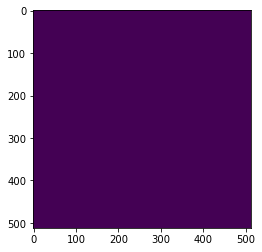

In [7]:
from matplotlib import pyplot as plt

plt.imshow(gan.masked_img[0])

C:\Users\MI2RL\anaconda3\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\MI2RL\anaconda3\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\MI2RL\anaconda3\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


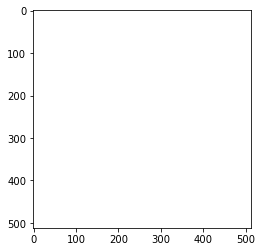

In [8]:
from matplotlib import pyplot as plt

plt.imshow(model_masked_img[0])

In [ ]:
valid_patch = np.ones(
    (gan.batch_size, *gan.disc_patch), dtype=np.float32)

generator_loss = gan.combined.train_on_batch(
    gan.original_img,
    [valid_patch, gan.masked_img],
    class_weight={0: 0.1, 1: 0.9}
)

In [ ]:
batch_i=0
batch_index = gan.loaded_data_index["train"][batch_i: batch_i +
                                              gan.batch_size]

In [ ]:
np.mean(gan.generator_losses[batch_index]) > np.quantile(gan.generator_losses, 0.1)

In [ ]:
# gan.load_study_info()
#gan.start_epoch = 30
# gan.start_epoch = 2 
gan.train(epochs=325, batch_size=batch_size, epoch_shuffle_term=100)
# gan.train(epochs=20, batch_size=batch_size, epoch_shuffle_term=100)

In [ ]:
temp_weight = gan.generator.weights

In [ ]:
for weight in temp_weight:
    if "dense" in weight.name:
        if "bias" in weight.name:
            print(weight.name)
            print(weight.numpy())


In [ ]:
temp_weight = gan.discriminator.weights

In [ ]:
for weight in temp_weight:
    if "dense" in weight.name:
        if "bias" in weight.name:
            print(weight.name)
            print(weight.numpy())


In [ ]:
gan.original_img

In [ ]:
np.max(gan.original_img.numpy())

In [ ]:
np.min(gan.original_img.numpy())

In [ ]:
(gan.original_img.numpy() + 1) * 127.5

In [ ]:
image = gan.original_img.numpy()
predicted = gan.generator.predict_on_batch(image)
mask = gan.masked_img.numpy()

image = ((image + 1) * 127.5).astype('uint8')
predicted = ((predicted + 1) * 127.5).astype('uint8')
mask = ((mask + 1) * 127.5).astype('uint8')

In [ ]:
index = 0

plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.imshow(image[index])

plt.subplot(132)
plt.imshow(predicted[index])

plt.subplot(133)
plt.imshow(mask[index])


In [ ]:
print(np.max(gan.original_img))
print(np.min(gan.original_img))
print(np.max(temp))
print(np.min(temp))

In [ ]:
temp = gan.data_loader.loaded_data_object["train"].values()

for index, (input_img, output_img) in enumerate(zip(*temp)):
    print(index)
    if index > 40:
        break
    print(index)
    print(input_img.shape)
    print(output_img.shape)
    

In [ ]:
import time

temp_source = gan.original_img
temp_mask = gan.masked_img

start_time = time.time()
gan.generator.train_on_batch(temp_source, temp_mask)
print(f"elapsed time : {time.time() - start_time}")

temp_source = tf.convert_to_tensor(temp_source)
temp_mask = tf.convert_to_tensor(temp_mask)

start_time = time.time()
gan.generator.train_on_batch(temp_source, temp_mask)
print(f"elapsed time : {time.time() - start_time}")

# Iterator : 260초
# Queue Iterator : 200초

In [ ]:
import time
import threading
from queue import Queue

ITER_NUM = 620
batch_size = 10

gan.generator.compile(
    loss=sm.losses.BinaryFocalLoss(),
    optimizer=Nadam(gan.generator_learning_rate),
    metrics=["accuracy"],
)

def batch_setter(queue):
    batch_i = 0
    count = 0
    while batch_i + gan.batch_size <= gan.data_loader.train_data_length and count < ITER_NUM:
        
        batch_index = gan.train_loaded_data_index[batch_i: batch_i +
                                                   gan.batch_size]        
        
        batch_tuple = gan.data_loader.get_data(
        data_mode="train", index=batch_index)

        queue.put(batch_tuple)
        queue.join()
        count += 1
    
def batch_getter(queue):
    
    original_img, masked_img = queue.get()
    tensor_original_img = tf.convert_to_tensor(original_img)
    tensor_masked_img = tf.convert_to_tensor(masked_img)
    queue.task_done()
    
    return tensor_original_img, tensor_masked_img
    
def batch_trainer(original_img, masked_img):
    
    gan.generator.train_on_batch(temp_source, temp_mask)

q = Queue()

setter = threading.Thread(target=batch_setter, args=(q,),daemon=True)
setter.start()
start_time = time.time()
for i in range(ITER_NUM):
    tensor_original_img, tensor_masked_img = batch_getter(q)
    
    gan.generator.train_on_batch(tensor_original_img, tensor_masked_img)
print(f"elapsed time : {time.time() - start_time}")

In [ ]:
start_time = time.time()
batch_i = 0
count = 0
while batch_i + gan.batch_size <= gan.data_loader.train_data_length and count < ITER_NUM:

    batch_index = gan.train_loaded_data_index[batch_i: batch_i +
                                               gan.batch_size]        
    batch_tuple = gan.data_loader.get_data(
    data_mode="train", index=batch_index)
    
    gan.generator.train_on_batch(*batch_tuple)
    
    count += 1
print(f"elapsed time : {time.time() - start_time}")

In [ ]:
import cv2

temp = tensor_masked_img
print(type(temp))
print(type(temp.numpy()))

In [ ]:
isinstance(temp.numpy(), tf.Tensor)

In [ ]:
from gan_module.model.build_model import build_dual_discriminator

temp = build_dual_discriminator(
            input_img_shape=(512,512,3),
            output_img_shape=(512,512,1),
            discriminator_power=1,
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Nadam

temp.compile(
    loss=[
        tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
    ],
    optimizer=Nadam(),
    metrics=["accuracy"],
)

In [ ]:
import numpy as np

image_mockup = np.ones((1,512,512,3))
mask_mockup = np.ones((1,512,512,1))
patch_mockup = np.ones((1,8,8,1))

temp.test_on_batch([image_mockup, mask_mockup], [patch_mockup, patch_mockup])